# 1. Cài đặt thư viện và Chuẩn bị dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Gold Futures Historical Data.csv to Gold Futures Historical Data.csv


# 2. Đọc và tiền xử lý dữ liệu

In [ ]:
df = pd.read_csv("Gold Futures Historical Data.csv")

# Đổi tên cột cho dễ xử lý
df.columns = ["Date", "Price", "Open", "High", "Low", "Volume", "Change"]

# Đổi format ngày và sắp xếp tăng dần theo thời gian
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

# Xử lý dữ liệu số: bỏ dấu "," và "%"
df["Price"] = df["Price"].str.replace(",", "").astype(float)
df["Open"] = df["Open"].str.replace(",", "").astype(float)
df["High"] = df["High"].str.replace(",", "").astype(float)
df["Low"] = df["Low"].str.replace(",", "").astype(float)
df["Volume"] = df["Volume"].str.replace("K", "").str.replace(",", "").astype(float) * 1_000
df["Change"] = df["Change"].str.replace("%", "").astype(float)

# Đặt cột Date làm index
df.set_index("Date", inplace=True)

df.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
2022-01-03,1800.1,1830.1,1833.0,1798.2,168310.0,-1.56
2022-01-04,1814.6,1801.1,1817.2,1798.1,167710.0,0.81
2022-01-05,1825.1,1815.2,1830.7,1808.2,173340.0,0.58
2022-01-06,1789.2,1810.6,1811.6,1785.4,238640.0,-1.97
2022-01-07,1797.4,1791.0,1798.4,1781.3,238930.0,0.46


In [ ]:
cols = ["Price", "Open", "High", "Low", "Volume", "Change"]
data = df[cols].copy()

# 3. Chia tập train/test

In [ ]:
split_index = int(len(data) * 0.9)  # 90% train, 10% test
train_df = data.iloc[:split_index]
test_df = data.iloc[split_index:]

# 4. Kiểm tra tính dừng và sai phân

In [ ]:
def check_stationarity(series, name):
    # Replace infinite values with NaN
    series = series.replace([np.inf, -np.inf], np.nan)
    # Drop rows with NaN values
    series = series.dropna()

    result = adfuller(series, autolag='AIC')
    print(f'ADF Test p-value cho {name}: {result[1]:.4f}')
    return result[1]

# Kiểm tra toàn bộ các cột và tự động sai phân nếu cần
d = 0  # Số lần sai phân
max_diff = 2  # Cho phép tối đa 2 lần sai phân
stationary = False
train_diff = train_df.copy()

while not stationary and d <= max_diff:
    p_values = []
    for col in ['Price', 'Open', 'High', 'Low', 'Volume', 'Change']:
        p_value = check_stationarity(train_diff[col], col if d == 0 else f"{col} (diff {d})")
        p_values.append(p_value)

    if all(p <= 0.05 for p in p_values):
       stationary = True
       print(f"Dữ liệu dừng sau sai phân bậc {d}.")
    else:
       print(f"Dữ liệu chưa dừng. Thực hiện sai phân bậc {d+1}.")
       train_diff = train_diff.diff().dropna()
       d += 1

print(f"Tổng số lần sai phân đã thực hiện: {d}")

# Cập nhật lại tập train sau khi sai phân
train_for_model = train_diff.copy()
# sai phân tập test giống tập train
test_diff = test_df.copy()
for i in range(d):
    test_diff = test_diff.diff().dropna()

test_for_model = test_diff.copy()

ADF Test p-value cho Price: 0.9933
ADF Test p-value cho Open: 0.9886
ADF Test p-value cho High: 0.9856
ADF Test p-value cho Low: 0.9838
ADF Test p-value cho Volume: 0.0000
ADF Test p-value cho Change: 0.0000
Dữ liệu chưa dừng. Thực hiện sai phân bậc 1.
ADF Test p-value cho Price (diff 1): 0.0000
ADF Test p-value cho Open (diff 1): 0.0000
ADF Test p-value cho High (diff 1): 0.0000
ADF Test p-value cho Low (diff 1): 0.0000
ADF Test p-value cho Volume (diff 1): 0.0000
ADF Test p-value cho Change (diff 1): 0.0000
Dữ liệu dừng sau sai phân bậc 1.
Tổng số lần sai phân đã thực hiện: 1


# 5. Chuẩn hóa dữ liệu

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_for_model)
train_scaled = pd.DataFrame(train_scaled, columns=train_for_model.columns, index=train_for_model.index)

test_scaled = scaler.transform(test_for_model)
test_scaled = pd.DataFrame(test_scaled, columns=test_for_model.columns, index=test_for_model.index)

# 6. Tối ưu bậc trễ

In [ ]:
def optimize_lag_order(train_data, max_lag):
    results = {}
    for lag in range(1, max_lag + 1): # Corrected indentation for the 'for' loop
        model = VAR(train_data)
        try:
            model_result = model.fit(lag)
            results[lag] = model_result.aic
        except Exception as e:
            print(f"Error fitting VAR with lag {lag}: {e}")
            results[lag] = float('inf')
    best_lag = min(results, key=results.get) # Corrected indentation
    print(f'Optimal lag order: {best_lag}') # Corrected indentation
    return best_lag # Corrected indentation

max_lag = 10
# Assuming 'train_scaled' is defined and scaled data
best_lag = optimize_lag_order(train_scaled, max_lag)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal lag order: 9


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# 7. Huấn luyện mô hình

In [ ]:
model = VAR(train_scaled)
model_fitted = model.fit(best_lag)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# 8. Dự báo và đánh giá

In [ ]:
model = VAR(train_scaled)
model_fitted = model.fit(best_lag)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
def forecast(model, data, steps, scaler, cols, diff=False, last_values=None):
      lag_order = model.k_ar
      forecast_input = data.values[-lag_order:]
      forecast = model.forecast(forecast_input, steps=steps)
      forecast_orig = scaler.inverse_transform(forecast)
      forecast_df = pd.DataFrame(forecast_orig, columns=cols)
      if diff:
         for col in cols:
             forecast_df[col] = last_values[col] + forecast_df[col].cumsum()
      return forecast_df

In [ ]:
forecast_test = forecast(model_fitted, train_scaled, len(test_df), scaler, train_for_model.columns,
                         diff=(d > 0),
                          last_values={col: train_df[col].iloc[-1] for col in cols}) # Change len(test_scaled) to len(test_df)
for col in cols:
    test_df[f"pred_{col}"] = forecast_test[col].values[:len(test_df)]

<ipython-input-12-e66505ba4d66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"pred_{col}"] = forecast_test[col].values[:len(test_df)]
<ipython-input-12-e66505ba4d66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"pred_{col}"] = forecast_test[col].values[:len(test_df)]
<ipython-input-12-e66505ba4d66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [ ]:
forecast_periods = {"10 ngày": 10, "30 ngày": 30, "60 ngày": 60, "90 ngày": 90}
forecasts = {}

for period_name, steps in forecast_periods.items():
    forecast_df = forecast(model_fitted, train_scaled, steps, scaler, train_for_model.columns,
                          diff=(d > 0),
                          last_values={col: train_df[col].iloc[-1] for col in cols})
    last_date = train_df.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='B')
    forecast_df["ds"] = forecast_dates
    forecast_df["pred"] = forecast_df["Price"]
    forecasts[period_name] = forecast_df


In [ ]:
# Đánh giá RMSE
def evaluate_forecast(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

rmse_price, mae_price = evaluate_forecast(test_df["Price"], test_df["pred_Price"])
print(f"Price - RMSE: {rmse_price:.2f}, MAE: {mae_price:.2f}")

Price - RMSE: 93.58, MAE: 76.81


# 9. Vẽ biểu đồ

In [ ]:
print(forecasts.keys())


dict_keys(['10 ngày', '30 ngày', '60 ngày', '90 ngày'])


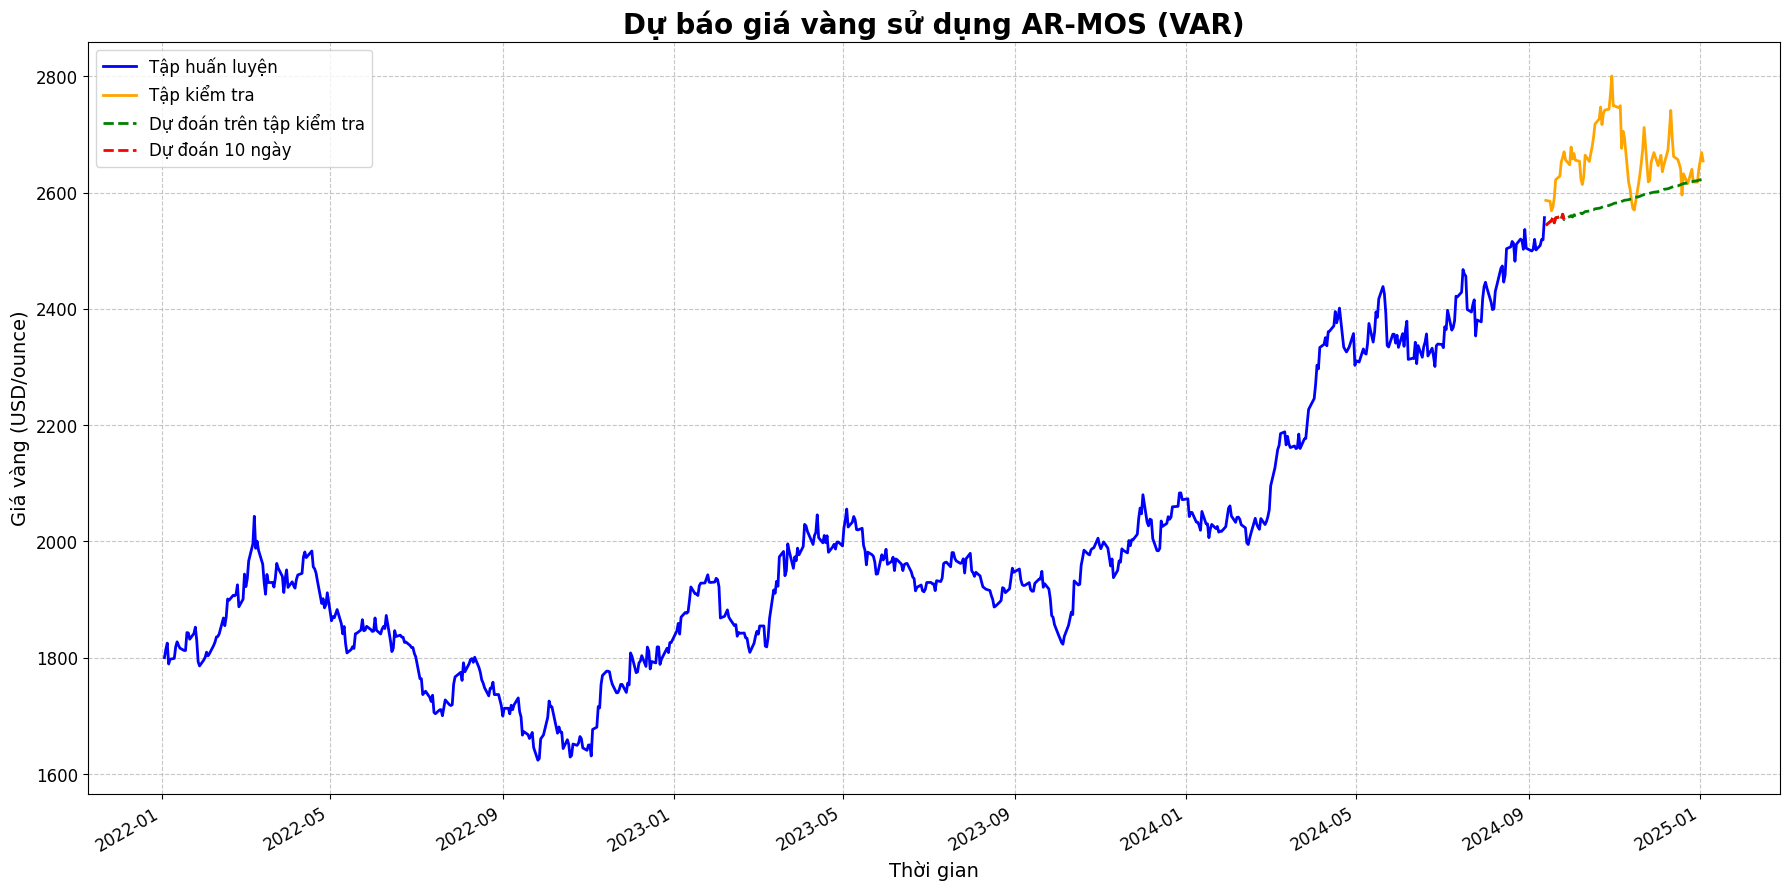

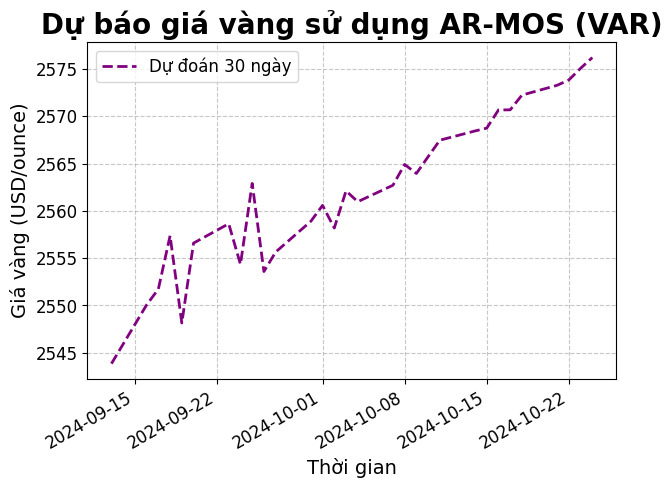

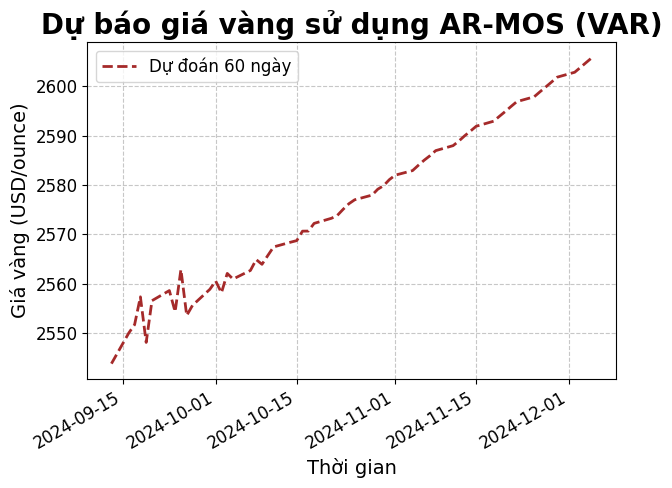

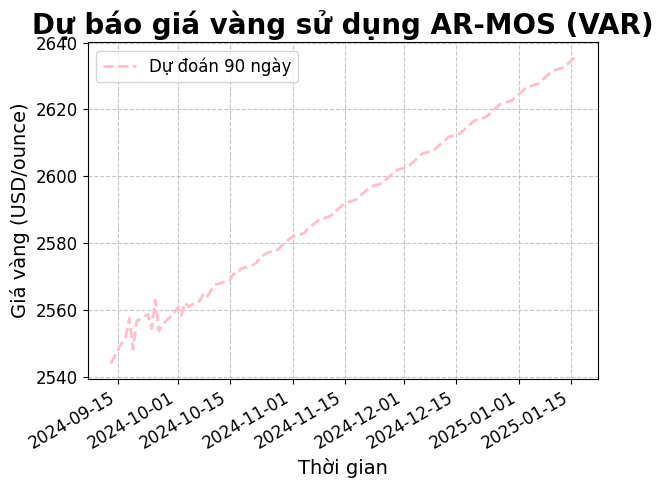

In [ ]:
plt.figure(figsize=(18,10))

# Vẽ giá vàng tập huấn luyện
plt.plot(train_df.index, train_df["Price"], label="Tập huấn luyện", color='blue', linewidth=2)

# Vẽ giá vàng tập kiểm tra
plt.plot(test_df.index, df.loc[test_df.index, "Price"], label="Tập kiểm tra", color='orange', linewidth=2)

# Vẽ dự đoán trên tập kiểm tra
plt.plot(test_df.index, test_df["pred_Price"], label="Dự đoán trên tập kiểm tra", color='green', linestyle='--', linewidth=2)

# Vẽ các dự báo tương lai
colors = ['red', 'purple', 'brown', 'pink']
for color, key in zip(colors, ["10 ngày", "30 ngày", "60 ngày", "90 ngày"]):
    plt.plot(forecasts[key]["ds"], forecasts[key]["pred"], label=f'Dự đoán {key}', color=color, linestyle='--', linewidth=2)

# Thiết lập phụ cho biểu đồ
plt.title("Dự báo giá vàng sử dụng AR-MOS (VAR)", fontsize=20, fontweight='bold')
plt.xlabel("Thời gian", fontsize=14)
plt.ylabel("Giá vàng (USD/ounce)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()
